In [1]:
import cv2
import numpy as np
import mediapipe as mp
import tensorflow as tf
from tensorflow.keras.models import load_model
import time
import datetime
import json
from pathlib import Path
from ipywidgets import Output, Button, Layout, HBox
from IPython.display import Image, display, clear_output
from matplotlib import pyplot as plt

class LabelingTool:
    def __init__(self, classes: list, images_path: str, labeled_data_path: str, position = 0) -> None:
        self.classes = classes
        self.path = Path(images_path)
        self.images = [f.name for f in self.path.glob("*.jpg")]
        self.labeled_data = {}
        self.labeled_data_path = labeled_data_path
        if (0 <= position < len(self.images)):
            self.position = position
        else:
            print("Position out of bound. Setting to 0 " + "number of images: " + str(len(self.images)))
            self.position = 0
            
    def _add_landmarks(self) -> None:
        mp_face_mesh = mp.solutions.face_mesh
        mpDraw = mp.solutions.drawing_utils
        mp_drawing_styles = mp.solutions.drawing_styles
        
        with mp_face_mesh.FaceMesh(
            max_num_faces=1,
            refine_landmarks=True,
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5) as face_mesh:
            
#             print(str(self.path)+ "\\" + current_image)
            
            image = cv2.imread(str(self.path)+ "\\" + self.images[self.position])
#             image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            resultFace = face_mesh.process(image)
            if resultFace.multi_face_landmarks:
                for face_landmarks in resultFace.multi_face_landmarks:
                    mpDraw.draw_landmarks(
                        image=image,
                        landmark_list=face_landmarks,
                        connections=mp_face_mesh.FACEMESH_TESSELATION,
                        landmark_drawing_spec=None,
                        connection_drawing_spec=mp_drawing_styles
                        .get_default_face_mesh_tesselation_style())
                    mpDraw.draw_landmarks(
                        image=image,
                        landmark_list=face_landmarks,
                        connections=mp_face_mesh.FACEMESH_CONTOURS,
                        landmark_drawing_spec=None,
                        connection_drawing_spec=mp_drawing_styles
                        .get_default_face_mesh_contours_style())
                    mpDraw.draw_landmarks(
                        image=image,
                        landmark_list=face_landmarks,
                        connections=mp_face_mesh.FACEMESH_IRISES,
                        landmark_drawing_spec=None,
                        connection_drawing_spec=mp_drawing_styles
                        .get_default_face_mesh_iris_connections_style())
        cv2.imwrite("temp.jpg", image)
        
    
    def _next_image(self, *args) -> None:
        """Select the next image and update the displays."""
        self.position += 1
        if self.position == len(self.images):
            self.position = 0

        # refresh display
        self._add_landmarks()
        image = Image("temp.jpg")
        o_image = Image(self.path / self.images[self.position])
        
        clear_output(wait=True)
        with self.o_frame:
            clear_output(wait=True)
            display(o_image)
        with self.frame:
            clear_output(wait=True)
            display(image)
        
        display(self.o_frame)
        display(self.frame)
        display(HBox(self.navigation_buttons))
        display(HBox(self.class_buttons))
        if (str(self.path)+"\\"+self.images[self.position]) in self.labeled_data:
            self.existing_label = []
            existing_label_button = Button(description="Label: " + self.labeled_data.get(str(self.path)+"\\"+self.images[self.position])[1])
            self.existing_label.append(existing_label_button)
            display(HBox(self.existing_label))

    def _previous_image(self, *args) -> None:
        """Select the previous image and update the displays."""
        self.position -= 1
        if self.position == -1:
            self.position = len(self.images) - 1

        # refresh display
        self._add_landmarks()
        image = Image("temp.jpg")
        o_image = Image(self.path / self.images[self.position])
        with self.o_frame:
            clear_output(wait=True)
            display(o_image)
        
        clear_output(wait=True)
        with self.frame:
            clear_output(wait=True)
            display(image)
            
        display(self.o_frame)
        display(self.frame)
        display(HBox(self.navigation_buttons))
        display(HBox(self.class_buttons))
        if (str(self.path)+"\\"+self.images[self.position]) in self.labeled_data:
            self.existing_label = []
            existing_label_button = Button(description="Label: " + self.labeled_data.get(str(self.path)+"\\"+self.images[self.position])[1])
            self.existing_label.append(existing_label_button)
            display(HBox(self.existing_label))

    def _store_labeled_data(self, button: Button) -> None:
        """Annotates the current image with the button's description."""
        # store label
        current_image = self.images[self.position]
#         display(current_image)
        mp_face_mesh_d = mp.solutions.face_mesh
        
        with mp_face_mesh_d.FaceMesh(
            max_num_faces=1,
            refine_landmarks=True,
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5) as face_mesh:
            
#             print(str(self.path)+ "\\" + current_image)
            
            image = cv2.imread(str(self.path)+ "\\" + current_image)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            resultFace = face_mesh.process(image)
            if resultFace.multi_face_landmarks:
                for face_landmarks in resultFace.multi_face_landmarks:
                    if face_landmarks:
                        #                         current_time = datetime.datetime.now(datetime.timezone.utc)
#                         if not (str(self.path)+"\\"+current_image) in self.labeled_data:
                            xyz = [(lm.x, lm.y, lm.z) for lm in face_landmarks.landmark]
                            self.labeled_data.update({(str(self.path)+"\\"+current_image) : (xyz, button.description)})
    #                         self.labeled_data[str(self.path)+ "\\" + current_image] = (xyzt, button.description)
#                             self._next_image()
            else:
                clear_output(wait=True)
                self.no_face = []
                label_button = Button(description="No face detected")
                self.no_face.append(label_button)
                display(self.frame)
                display(HBox(self.navigation_buttons))
                display(HBox(self.no_face))
        # move on
    def plot_scatter(self) -> None:
        %matplotlib notebook
        data_list = list(tool.labeled_data.keys())
        # display(data_list)
        current_image=str(tool.path)+"\\"+tool.images[tool.position]
        points = np.array(tool.labeled_data.get(current_image)[0])
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection="3d")
        ax.scatter(points[:, 0], points[:, 1], points[:, 2])
        ax.set_title(
                "image: {:}, label: {:}".format(
                    data_list[-1], tool.labeled_data.get(current_image)[1]
                )
        )
        ax.set_axis_off()
        plt.show()
    
    def load_labeled_data_from_file(self) -> None:
        with open((self.labeled_data_path), "r") as outfile:
            self.labeled_data = json.load(outfile)
        
    def save_labeled_data_to_file(self) -> None:
        labeled_data_json = json.dumps(self.labeled_data, indent=4)
        with open((self.labeled_data_path), "w") as outfile:
            outfile.write(labeled_data_json)
        
    def start(self) -> None:
        try:
            self.load_labeled_data_from_file()
        except:
            print("No saved data")
        o_image = Image(self.path / self.images[self.position])
        self.frame = Output(layout=Layout(height="300px", max_width="300px"))
        self.o_frame = Output(layout=Layout(height="300px", max_width="300px"))
        
        with self.o_frame:
            clear_output(wait=True)
            display(o_image)
        
        self._add_landmarks()
        image = Image("temp.jpg")
        with self.frame:
            clear_output(wait=True)
            display(image)

        # navigation buttons
        backward_button = Button(description="< go back")
        backward_button.on_click(self._previous_image)
        forward_button = Button(description="next >")
        forward_button.on_click(self._next_image)
        self.navigation_buttons = [backward_button, forward_button]

        # class label buttons
        self.class_buttons = []
        for label in self.classes:
            label_button = Button(description=label)
            label_button.on_click(self._store_labeled_data)
            self.class_buttons.append(label_button)
        display(self.o_frame)
        display(self.frame)
        # display contents
        display(HBox(self.navigation_buttons))
        display(HBox(self.class_buttons))
        if (str(self.path)+"\\"+self.images[self.position]) in self.labeled_data:
            self.existing_label = []
            existing_label_button = Button(description="Label: " + self.labeled_data.get(str(self.path)+"\\"+self.images[self.position])[1])
            self.existing_label.append(existing_label_button)
            display(HBox(self.existing_label))

In [2]:
tool = LabelingTool(images_path="./Our_images/", classes = ["open_mouth", "closed_mouth"], labeled_data_path="./our_labaled_data.json",  position=0)
#wikicrop01,317
tool.start()


Output(layout=Layout(height='300px', max_width='300px'), outputs=({'output_type': 'display_data', 'data': {'im…

Output(layout=Layout(height='300px', max_width='300px'), outputs=({'output_type': 'display_data', 'data': {'im…

In [8]:
# display(tool.labeled_data.get("wiki_crop\\00\\12170800_1982-12-15_2013.jpg")[1])
display(tool.position)

40

0

<IPython.core.display.Javascript object>


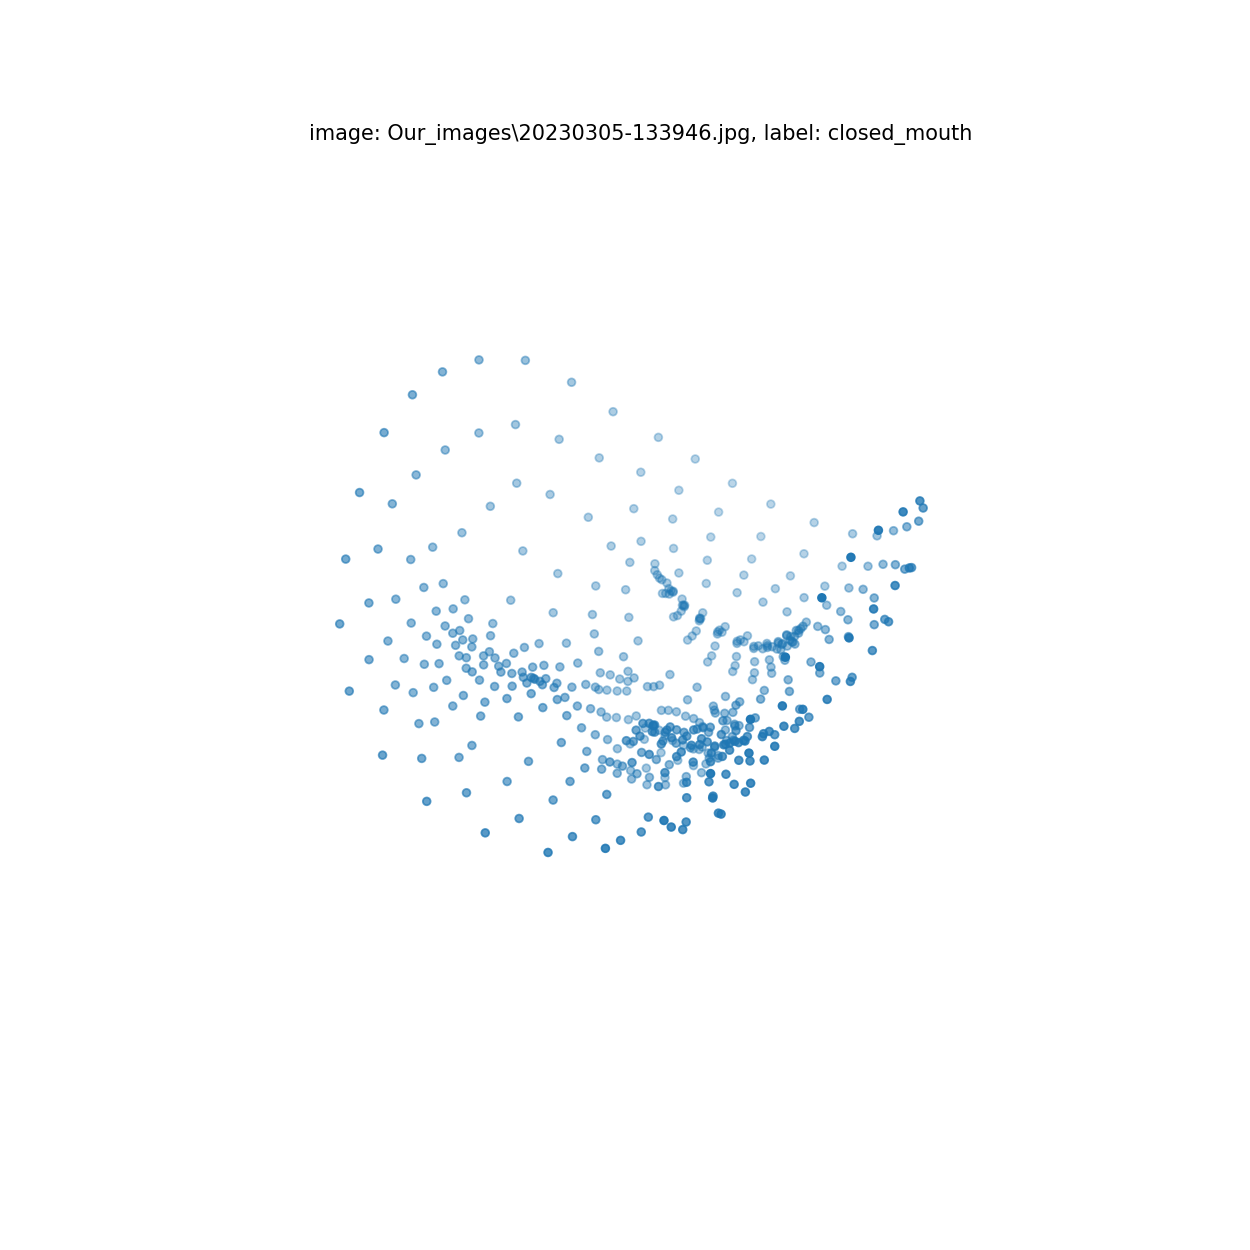

In [9]:
display(tool.position)
tool.save_labeled_data_to_file()
tool.plot_scatter()

In [5]:
tool.save_labeled_data_to_file()

<IPython.core.display.Javascript object>


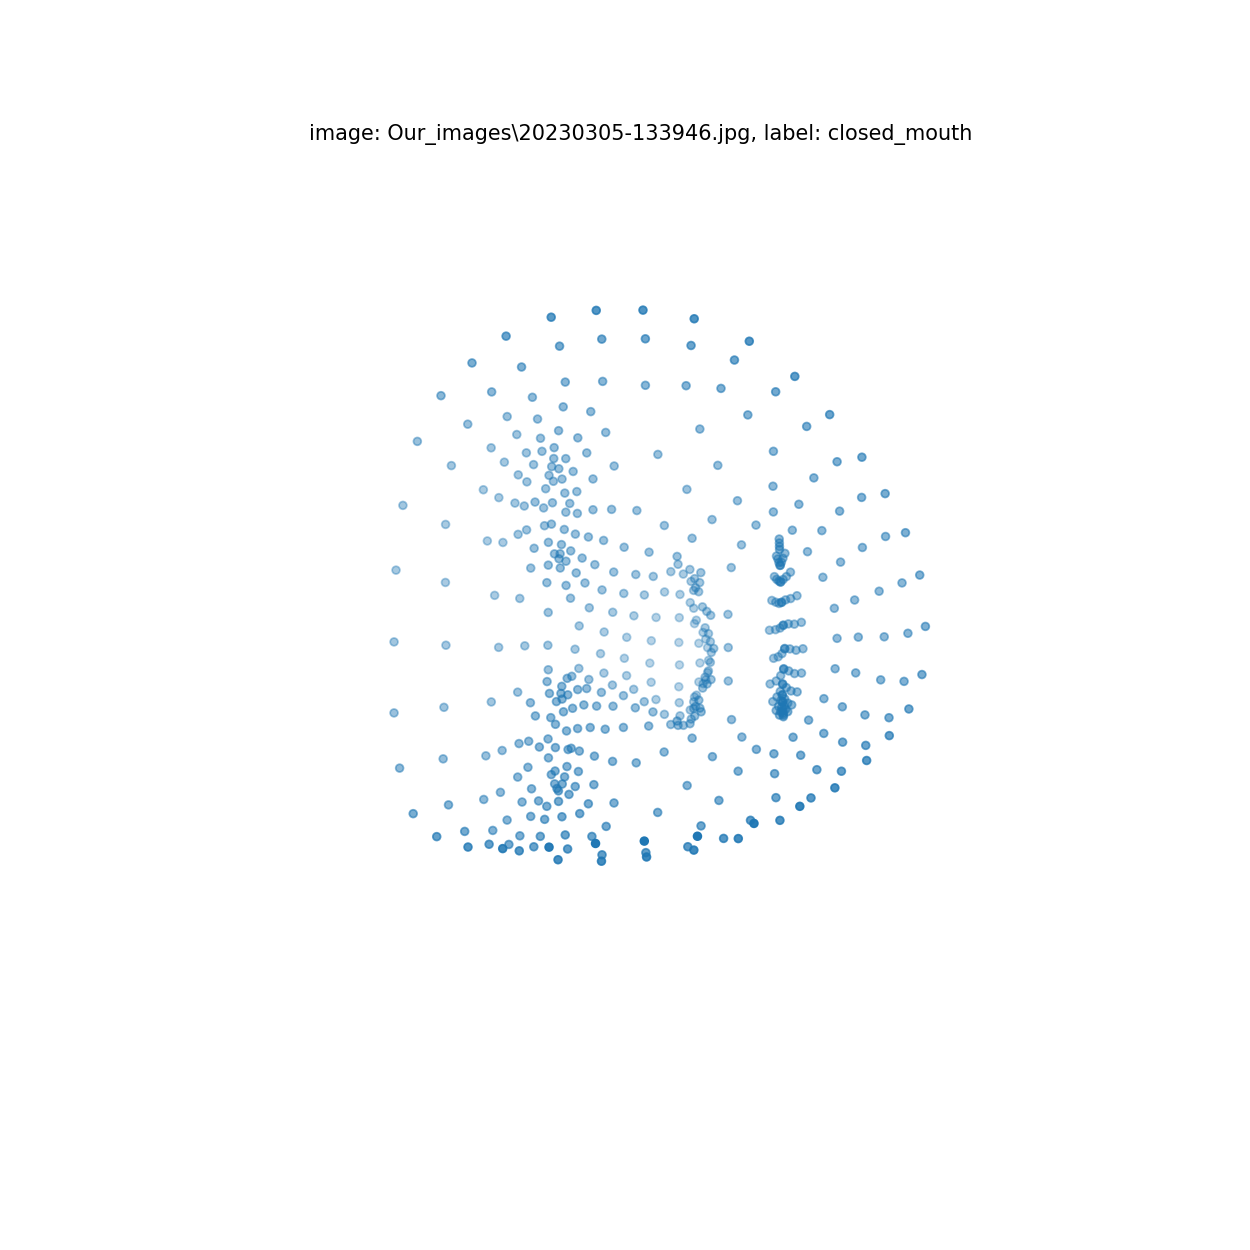

In [11]:
%matplotlib notebook
data_list = list(tool.labeled_data.keys())
# display(data_list)
current_image=str(tool.path)+"\\"+tool.images[tool.position]
points = np.array(tool.labeled_data.get(current_image)[0])
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_title(
        "image: {:}, label: {:}".format(
            data_list[-1], tool.labeled_data.get(current_image)[1]
        )
)
ax.set_axis_off()
plt.show()

# display(points)
# display(str(tool.path)+ "\\" + tool.images[tool.position-1])
# display(data_list.index(str(tool.path)+ "\\" + tool.images[tool.position-1]))

In [7]:
current_image=str(tool.path)+"\\"+tool.images[tool.position]
display(tool.position)
tool.labeled_data.pop(current_image)

133

[[[0.5127929449081421, 0.5775076150894165, -0.048773881047964096],
  [0.6155773401260376, 0.509922981262207, -0.08940650522708893],
  [0.5839366912841797, 0.5288068056106567, -0.05032108724117279],
  [0.5885745286941528, 0.44570469856262207, -0.07530108094215393],
  [0.6189727783203125, 0.4901471734046936, -0.09390512853860855],
  [0.6126651167869568, 0.4655075967311859, -0.08620046079158783],
  [0.5899325013160706, 0.4035656750202179, -0.040435586124658585],
  [0.4309169054031372, 0.377374529838562, -0.05171265825629234],
  [0.5874950289726257, 0.359805166721344, -0.02650357037782669],
  [0.5919070243835449, 0.3354741334915161, -0.027646323665976524],
  [0.5894359350204468, 0.23621883988380432, -0.0055246902629733086],
  [0.5118480920791626, 0.5856028199195862, -0.04697703942656517],
  [0.5115107893943787, 0.593606173992157, -0.04267645627260208],
  [0.5120771527290344, 0.5991470813751221, -0.03578415885567665],
  [0.5105652213096619, 0.6058224439620972, -0.02718096598982811],
  [0.50

In [103]:
len(tool.labeled_data)

41

In [16]:
display(min(points[:, 1]))

0.3754432201385498